<div align=right><img src=keysight-logo.png align=right></div>
<h1>Python Automation of Keysight Instruments</h1>
*Note: This app note assumes a CPython installation on a Windows machine and assumes some prior knowledge and installation of Python.*
<br>
<h4>Contents</h4>
<ul>
<li><a href="#General">General SCPI Instrumentation Control</a><br>
<li><a href="#Digital_Test_Apps">Automation of Keysight Digital Test Applications</a><br>
<li><a href="#N5990A">Automation of N5990A Automated Test Applications for Receiver Test</a>
</ul>

<h2><a id="General">General SCPI Instrumentation Control</a></h2>
<p>
    Requirements:<br>
<ol>
<li>Installation of a VISA library such as [Keysight's IO Libraries](http://www.keysight.com/find/iolibs)<br>
<li>Installation of the [PyVISA](https://github.com/hgrecco/pyvisa) Python library<br>
</ol>
</p>
<p>Example below uses [N8900A Infiniium Offline Oscilloscope software](www.keysight.com/find/N8900A):</p>

In [1]:
import visa # Import the instrument function from the visa module
rm = visa.ResourceManager()
scope = rm.open_resource("TCPIP0::localhost::inst0::INSTR") # Connect to the scope using the VISA address (see below)
scope.query("*IDN?") # Query the IDN properties of the scope

u'KEYSIGHT TECHNOLOGIES,N8900A,No Serial,05.20.0008\n'

If using Keysight's IO Libraries to provide the VISA labraries you can get the VISA address from there:<br>
<img src="files/IOLibs.jpg" width="750" height="450">

Now let's do something more interesting...

Infiniium has a nice demo wizard which we can use to load an example setup and waveform. In this example we will use the Real-Time Eye example as shown below:<br>
<img src="files/RTEye_Demo_Center.jpg" width="750" height="450"><br>
How about a screenshot from the instrument to confirm that the demo example loaded?

C:\Anaconda\lib\site-packages\pyvisa\ctwrapper\functions.py:1569: VisaIOWarning: VI_SUCCESS_MAX_CNT (1073676294): The number of bytes transferred is equal to the requested input count. More data may be available.
  ret = library.viRead(session, buffer, count, byref(return_count))


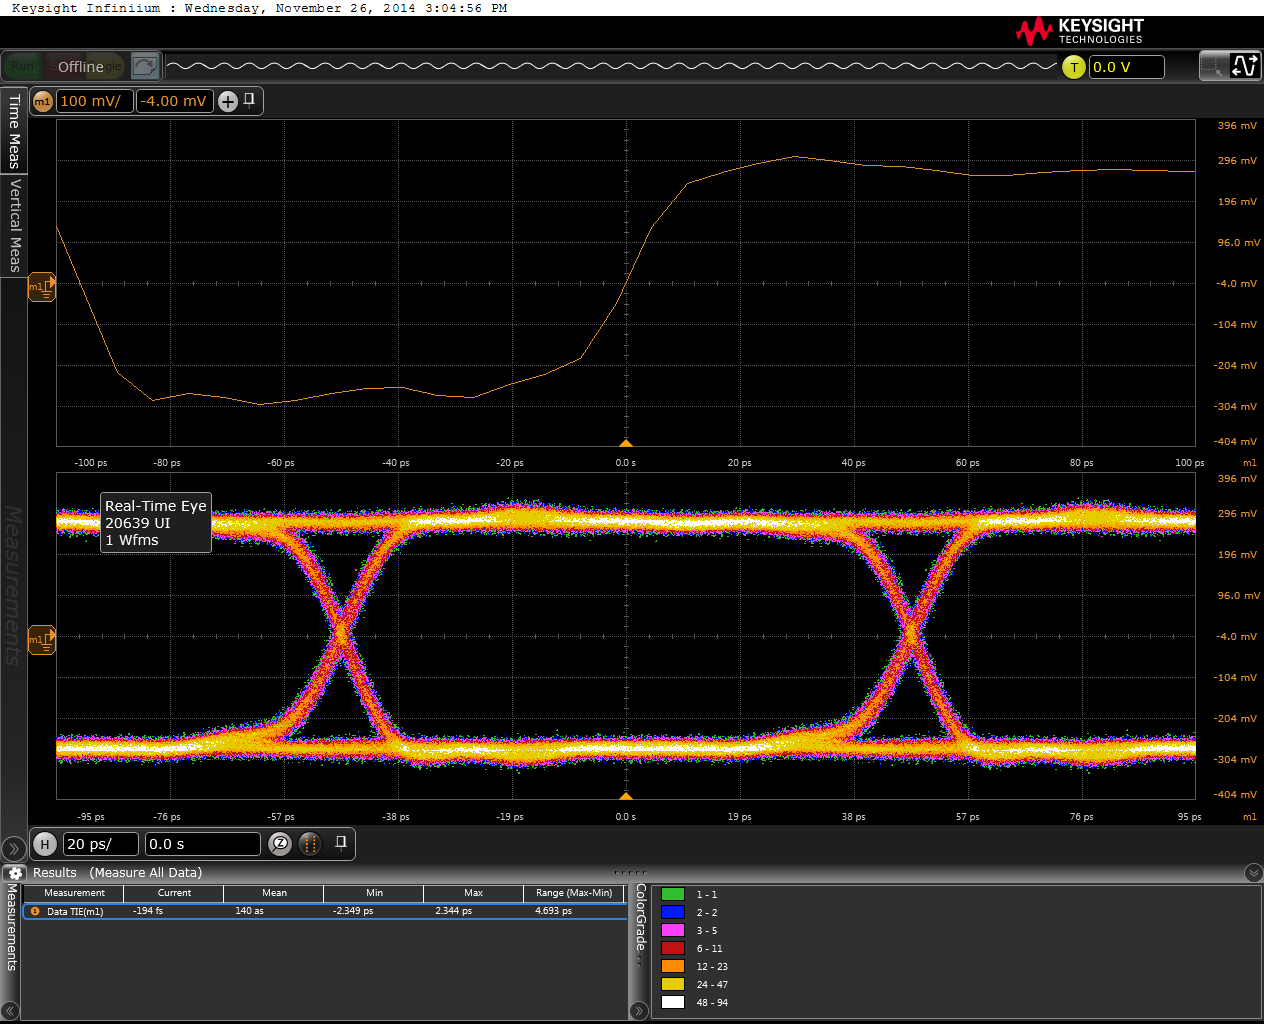

In [2]:
scope.write("disp:data? png")
data = scope.read_raw()    # Read back the raw binary data as a string
hash_idx = data.find('#')    # Find the start of the image data
len_datalen = int(data[hash_idx+1])    # The 1st character after '#' indicates the length of the length field
data_start_idx = hash_idx+len_datalen+2    # The binary image data starts here
datalen = int(data[hash_idx+2:hash_idx+len_datalen+2])    # The length of the binary data
img_data = data[data_start_idx:data_start_idx+datalen]    # Extract just the image binary data

from IPython.display import Image # Ipython has some nice tools to display image data.
embed = Image(img_data)
embed

In [3]:
target = open('screenshot.png','wb')
target.write(img_data)
target.close()

Now let's try pulling some waveform data from the scope. First we'll just grab the first 1000 samples so that we can plot them easily:

Populating the interactive namespace from numpy and matplotlib


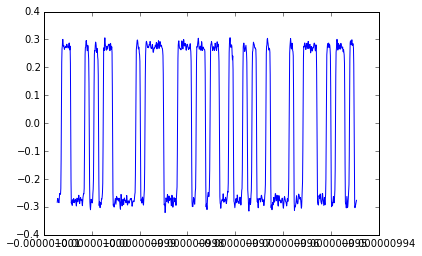

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Allow plots to appear inline with the IPython notebook
%pylab inline
scope.read_termination = '\n' # For ascii transfers the read is terminated with a newline character
scope.write(":WAV:SOUR WMEM1")
scope.write(":WAV:FORMAT ASCII")
wfm_ascii = scope.query(":WAV:DATA? 1, 1000") # Get the first 1000 points of waveform data
wfm_ascii = wfm_ascii[:-1] # Remove a trailing ','
wfm = [float(s) for s in wfm_ascii.split(',')] # Convert the ascii list of strings to a list of floats
x_inc = float(scope.query(":WAV:XINC?")) # Get the waveform's X increment
x_or = float(scope.query(":WAV:XOR?")) # Get the waveform's X origin
#mem_depth = float(scope.query(":ACQ:POIN?")) # Get the current memory depth
#t = np.linspace(-mem_depth/sa_rate,mem_depth/sa_rate, len(wfm)) # Calculate the sample times of the waveform
t = np.linspace(x_or, x_or+1001*x_inc, 1000) # Calculate the sample times of the waveform
plt.plot(t,wfm) # Plot the waveform vs sample times

Now let's try grabbing the whole waveform. First we'll try using the method above using ascii just to see how slow the transfer is. We'll use the python time module to time the transfer:

Number of Wfm Sample Points: 320230
ASCII Transfer Time: 0.344186125457
Time to grab ASCII wfm & convert to array: 0.570182696058
Check size of wfm array :320230


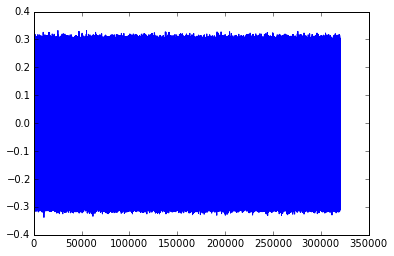

In [5]:
import time
num_pts = int(scope.query(":WAV:POIN?")) # Get the number of sample points in the waveform
print ("Number of Wfm Sample Points: "+str(num_pts))
start = time.clock() # Grab the current system time & store it
wfm_ascii = scope.query(":WAV:DATA?") # Grab the whole waveform
transfer_time = time.clock()-start # Calculate the time to transfer the waveform
print("ASCII Transfer Time: "+str(transfer_time))
wfm_ascii = wfm_ascii[:-1] # Remove a trailing ','
wfm = [float(s) for s in wfm_ascii.split(',')] # Convert the ascii list of strings to a list of floats
wfm_array = np.array(wfm)
wfm_to_array_time = time.clock()-start
print("Time to grab ASCII wfm & convert to array: "+str(wfm_to_array_time))
print("Check size of wfm array :"+str(len(wfm_array)))
plt.plot(wfm_array)

We can greatly simplify & reduce the transfer time by using a binary format to transfer the data & the new query_binary_values function introduced in PyVISA 1.6.<br>
<i>[More information on reading & writing binary data with PyVISA](http://pyvisa.readthedocs.org/en/1.6/rvalues.html)</i>:

Time to grab binary wfm & convert to array of integers: 0.0574108663971
Time to grab binary wfm, convert to array of floats: 0.0606590857776
Check size of wfm array :320230


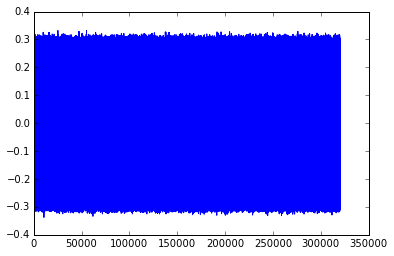

In [6]:
# The WORD format is the most accurate for Keysight Oscilloscopes. Data is transferred as signed 16bit integers in 2 bytes.
scope.write(":WAV:FORMAT WORD")
scope.write(":WAV:BYTEORDER MSBF") # Set the byte order to Big-Endian (default for Infinium oscilloscopes)
scope.read_termination = None # Since we're transferring binary data we need to remove the newline read termination
start = time.clock()
wfm_array = scope.query_binary_values(":WAV:DATA?", 'h', is_big_endian = True, container = np.array)
wfm_to_array_ints_time = time.clock()-start
print("Time to grab binary wfm & convert to array of integers: "+str(wfm_to_array_ints_time))
y_inc = float(scope.query(":WAV:YINC?"))
y_or = float(scope.query(":WAV:YOR?"))
wfm_array = wfm_array*y_inc + y_or
wfm_to_array_floats_time = time.clock()-start
print("Time to grab binary wfm, convert to array of floats: "+str(wfm_to_array_floats_time))
print("Check size of wfm array :"+str(len(wfm_array)))
plt.plot(wfm_array)

<hr>
<h2><a id="Digital_Test_Apps">Automation of Digital Test Applications</a></h2>
*You can find more information about our scope apps at: [www.keysight.com/find/scope-apps](http://www.keysight.com/find/scope-apps)*<br>
<br>Requirements:<br>
<ol>
    <li>Installation of [PythonNet](https://github.com/pythonnet/pythonnet)<br>
        Installation of PythonNet essentially involves putting the appropriate version of the files **clr.pyd** & **Python.Runtime.dll** where Python can access them. However care must be taken to match the appropriate versions (32/64 bit, Python 2.x, CLR 2.0/4.0). The source code is available at the link above if you're brave and want to build it yourself however if you have the Python package manager pip installed you should be able to install the appropriate version using<br>
        *pip install pythonnet*<br>
        This should copy the correct version of DLL's somewhere Python can access them (ex: C:\Python27\DLLS\)<br>
        **[Note: As of September 19th 2017 only version 2.0.0.0 of pythonnet is supported. This can be installed using pip install pythonnet==2.0.0.0]**
<br>
    <li>Installation of the [Remote Programming Toolkit](http://www.keysight.com/find/rpi)<br>
    * Note that with the transition from Agilent to Keysight there is a change in the Remote Toolkit naming conventions for Digital Test Apps. The user must select the appropriate version to use:<br>
    <ul>
        <li>For control of **both** Agilent & Keysight branded apps the user should select the files in the folder "Agilent-Keysight Transition"<br>
        <li>For control only of newer Keysight branded apps the user should use the files in the folder "Keysight Apps Only".*
        </ul><br>
    The user must either copy the .config/.dll/.xml files in the Tools directory to their Python DLL's directory or temporarily modify the PATH that python searches to find them (see example below)<br>
<br>
    <li>The Remote Programming Interface for the Infiniium Compliance Applications is built on a .NET API and requires a **LAN connection** to the scope.<br>
</ol>

Example using Keysight branded app:

In [2]:
# First set up the connection to the RPI DLL via the Python for .NET module
import clr # Import the Common Runtime Library Python module
import sys
sys.path.append("C:\ProgramData\Keysight\DigitalTestApps\Remote Toolkit\Version 3.30\Keysight Apps Only\Tools")
clr.AddReference("Keysight.DigitalTestApps.Framework.Remote") # Create a reference from CLR to the Compliance App DLL
from Keysight.DigitalTestApps.Framework.Remote import * # Import the entire compliance app namespace from the Compliance App DLL
scopeIpAddress = "localhost"

Now we're ready to start...

In [4]:
scope.write(":SYSTEM:LAUNCH 'U7231B/U7231C DDR3 Test App'") # Launch the compliance app using the pyvisa instrument connection
remoteAteOptions = GetRemoteAteOptions()
remoteAteOptions.CloseStartupMessageBoxes = True # Kills any message boxes that may be launched on app startup
remoteAteOptions.IpAddress = scopeIpAddress # Tells the Remote Interface where the scope app is running
remoteAteOptions.ScopeAppAddressOrAlias = "lan[localhost]:inst0" # Tells the Remote Interface where the Digital Test App is running
remoteAteOptions.TimeoutInSeconds = 60 # Sets the timeout for the Digital Test App to respond [s]
remoteObj = RemoteAteUtilities.GetRemoteAteCustom(remoteAteOptions) # Connect the Remote Interface to the Digital Test App
remoteApp = IRemoteAte(remoteObj)

First we must make some selections about the device we want to test.<br>
If we want to take a look at the test ID's & test names currently available we can do that using the TestInfo type:

In [5]:
remoteApp.SetConfig("DeviceType", "DDR3-1600")
remoteApp.SetConfig("TestMode", "Compliance")
remoteApp.SetConfig("BurstTrigMethod", "DQS-DQ Phase Difference")
remoteApp.SetConfig("AcLevels_DQ", "150")
remoteApp.SetConfig("AcLevels_CA", "150")
testsinfos = remoteApp.GetCurrentOptions("TestsInfo")
for test in testsinfos:
    print test.ID, test.Name

100 tjit(CC) Rising Edge Measurements
200 tCK(avg) Rising Edge Measurements
300 tjit(per) Rising Edge Measurements
400 terr(2per) Rising Edge Measurements
500 terr(3per) Rising Edge Measurements
600 terr(4per) Rising Edge Measurements
700 terr(5per) Rising Edge Measurements
800 terr(6per) Rising Edge Measurements
900 terr(7per) Rising Edge Measurements
1000 terr(8per) Rising Edge Measurements
1100 terr(9per) Rising Edge Measurements
1200 terr(10per) Rising Edge Measurements
1300 terr(11per) Rising Edge Measurements
1400 terr(12per) Rising Edge Measurements
2000 tCH Average High Measurements
2050 tCL Average Low Measurements
2100 tjit(duty-high) Jitter Average High Measurements
2150 tjit(duty-low) Jitter Average Low Measurements
3000 terr(nper) Rising Edge Measurements
2200 tCH(abs) Absolute clock HIGH pulse width
2250 tCL(abs) Absolute clock LOW pulse width
10313 VIH.DQ(AC)
10314 VIH.DQ(DC)
10323 VIL.DQ(AC)
10324 VIL.DQ(DC)
10353 Overshoot amplitude (Clock, Data, Strobe, Mask)
10354 Ov

Now let's select some measurements & run some tests:

In [9]:
remoteApp.SuppressMessages = True # Suppress the GUI prompts
# Set various Configuration Parameters
remoteApp.SelectedTests = [10313, 10314, 10323, 10324] # Select the tests to run
remoteApp.Run() # Run the selected tests
# Set up the project save options & save it to disk
saveOptions = SaveProjectOptions()
saveOptions.BaseDirectory = "c:\\temp"
saveOptions.Name = "Demo"
saveOptions.OverwriteExisting = True
projectFullPath = remoteApp.SaveProjectCustom(saveOptions)
# Set up the project results options and then get the results
resultOptions = ResultOptions()
resultOptions.TestIds = [10313, 10314, 10323, 10324]
resultOptions.IncludeCsvData = True
customResults = remoteApp.GetResultsCustom(resultOptions)
results = customResults.CsvResults
#remoteApp.Exit(True,True) # Exit the application

In [10]:
# An example of how to manipulate and display results using the Pandas library
import pandas as pd
from StringIO import StringIO
df_data = pd.read_csv(StringIO(results), sep=',', header=0, quotechar = '"')
pd.set_option('display.max_colwidth', 22)
df_data

Test ID   Test Name          Measured Item   Trial 1 Value
0     10313  VIH.DQ(AC)              Worst VIH     (See image)
1     10313  VIH.DQ(AC)  Number of burst(s)...               1
2     10313  VIH.DQ(AC)           Actual Value  1.088404000000
3     10313  VIH.DQ(AC)              NumOfMeas           2.000
4     10313  VIH.DQ(AC)                 Margin            17.7
5     10313  VIH.DQ(AC)                    PUT             DQ0
6     10313  VIH.DQ(AC)                PUT Src       Channel 3
7     10313  VIH.DQ(AC)         Supporting Pin      DQS0,/DQS0
8     10313  VIH.DQ(AC)     Supporting Pin Src       Channel 2
9     10313  VIH.DQ(AC)  Chip Select Pin So...             NaN
10    10313  VIH.DQ(AC)  PassLimit Min (Vre...           0.925
11    10314  VIH.DQ(DC)              Worst VIH     (See image)
12    10314  VIH.DQ(DC)  Number of burst(s)...               1
13    10314  VIH.DQ(DC)           Actual Value  1.088398000000
14    10314  VIH.DQ(DC)              NumOfMeas           2.000
15    10314  VIH.DQ(DC)                 Margin            36.7
16    10314  VIH.DQ(DC)                    PUT             DQ0
17    10314  VIH.DQ(DC)                PUT Src       Channel 3
18    10314  VIH.DQ(DC)         Supporting Pin      DQS0,/DQS0
19    10314  VIH.DQ(DC)     Supporting Pin Src       Channel 2
20    10314  VIH.DQ(DC)  Chip Select Pin So...             NaN
21    10314  VIH.DQ(DC)  PassLimit Min (Vre...            0.85
22    10314  VIH.DQ(DC)  PassLimit Max (VDD...  1.500000000000
23    10323  VIL.DQ(AC)              Worst VIL     (See image)
24    10323  VIL.DQ(AC)  Number of burst(s)...               1
25    10323  VIL.DQ(AC)           Actual Value       0.4161437
26    10323  VIL.DQ(AC)              NumOfMeas           2.000
27    10323  VIL.DQ(AC)                 Margin            27.6
28    10323  VIL.DQ(AC)                    PUT             DQ0
29    10323  VIL.DQ(AC)                PUT Src       Channel 3
30    10323  VIL.DQ(AC)         Supporting Pin      DQS0,/DQS0
31    10323  VIL.DQ(AC)     Supporting Pin Src       Channel 2
32    10323  VIL.DQ(AC)  Chip Select Pin So...             NaN
33    10323  VIL.DQ(AC)  PassLimit Max (Vre...           0.575
34    10324  VIL.DQ(DC)              Worst VIL     (See image)
35    10324  VIL.DQ(DC)  Number of burst(s)...               1
36    10324  VIL.DQ(DC)           Actual Value       0.4161437
37    10324  VIL.DQ(DC)              NumOfMeas           2.000
38    10324  VIL.DQ(DC)                 Margin            36.0
39    10324  VIL.DQ(DC)                    PUT             DQ0
40    10324  VIL.DQ(DC)                PUT Src       Channel 3
41    10324  VIL.DQ(DC)         Supporting Pin      DQS0,/DQS0
42    10324  VIL.DQ(DC)     Supporting Pin Src       Channel 2
43    10324  VIL.DQ(DC)  Chip Select Pin So...             NaN
44    10324  VIL.DQ(DC)  PassLimit Max (Vre...            0.65

<hr>
<h2><a id="N5990A">Automation of N5990A Automated Test Applications for Receiver Test</a></h2>
*More information about [N5990A solutions](http://www.keysight.com/en/pd-734301-pn-N5990A)*<br>
<br>
Requirements:<br>
<ol>
    <li>Installation of PythonNet (see above)
<br>
    <li>The Valiframe dll’s that are needed are typically installed in the following directory: C:\Program Files (x86)\BitifEye\ValiFrame\PCI-Express3
You can copy over the ones you need to a directory that Python looks in but the easiest way to reference them from your Python script is to add this directory to the sys.path variable which tells the Python interpreter where to look for modules and dll’s.<br>
</ol>

Example:

In [3]:
import sys 
sys.path.append('C:\\Program Files (x86)\\BitifEye\\ValiFrame\\PCI-Express3') # Add the location of the Valiframe dll's to the system path
import clr # Import the Common Runtime Library Python module
clr.AddReference("ValiFrameRemote") # Create a reference from CLR to the Valiframe App DLL
from BitifEye.ValiFrame.ValiFrameRemote import * # Import the entire valiframe app namespace from the DLL
my_vf_pcie = ValiFrameRemote() # Creates an instance of the ValiFrameRemote class
my_vf_pcie.InitApplication("PciExpress3") # Initialize the application
my_vf_pcie.LoadProject("my_pcie3_proj.vfp")
#my_vf_pcie.ConfigureApplication() # This method creates a GUI prompt

There are a couple of interesting things to be aware of when using .NET dll's in Python via the pythonnet module.<br>
<ol>
    <li>A .NET method may require the user to pass the variable name it wishes to modify as an argument. Python does not support "pass by reference" but the variable name must exist in python before it can be handed to the .NET method. The .NET method will simply point to the new instance.<br>
        The example below shows how to handle this.
    <li> .NET attributes can often return .NET collections such as Arrays. The object returned by python.net is indexed and iterable in Python but it is not a native Python collection object like a list.<br>
        The example below shows a simple way to convert Arrays of Strings and Int32s to lists of strings & ints.
</ol>

In [4]:
procedureIDs = procedureNames = [] # The variable names must be assigned to something but are overwritten in the next call
_, procedureIDs, procedureNames = my_vf_pcie.GetProcedures(procedureIDs, procedureNames)
procedureIDs = [int(id) for id in procedureIDs] # Convert to a python list of integers
procedureNames = [str(name) for name in procedureNames] # Convert to a python list of strings
procs = zip(procedureIDs, procedureNames) # Zip the id's & names together. A dictionary may also be a useful way to store these.
for proc_id,proc_name in procs:
    print proc_id, proc_name

300101 Random Jitter Calibration
300103 De-Emphasis Calibration
300104 Eye Height Calibration
301101 Random Jitter Calibration
301103 De-Emphasis Calibration
301104 Eye Height Calibration
302120 Equalization Preset Calibration
302121 Equalization Custom Preset Calibration
302122 Random Jitter Calibration
302123 Sinusoidal Jitter Calibration
302125 DM Sinusoidal Interference Calibration
302126 Eye Height and Width Calibration
302127 Compliance Eye Calibration
310101 Compliance Test
311101 Compliance Test
312120 Preset Compliance Test
312121 Compliance Test
320101 Unit Interval 
320102 Template Tests 
320103 Median to Max Jitter 
320104 Eye-Width 
320105 Peak Differential Output Voltage (Transition)
320106 Peak Differential Output Voltage (NonTransition)
321140 Unit Interval 
321141 Template Tests -3.5dB 
321142 Peak Differential Output Voltage -3.5dB 
321143 Eye-Width -3.5dB with crosstalk 
321144 RMS Random Jitter -3.5dB with crosstalk 
321145 Maximum Deterministic Jitter -3.5dB with c

Valiframe often uses dialog windows to give the user information or prompt the user to make a change to the setup.
There are different ways to handle this in an automation environment. Below is a basic way to suppress all dialog windows but there is a more complete example of [how to handle messaging and events in Valiframe](N5990A_Python_Automation.ipynb)

In [5]:
my_vf_pcie.DialogPopUp += DialogShowEventHandler(VFDialogInformation()) # Register the Dialog event handler (suppresses all Dialogs)

In [6]:
eyewidth_result = str()
my_vf_pcie.RunProcedure(320104, eyewidth_result)

(True,
 u'<?xml version="1.0" encoding="utf-16"?>\r\n<TestResults>\r\n  <Summary>\r\n    <ProcedureName>Eye-Width </ProcedureName>\r\n    <ProcedureID>320104</ProcedureID>\r\n    <Result>Incomplete</Result>\r\n    <DateTime>11/13/2013 12:32:21 PM</DateTime>\r\n  </Summary>\r\n</TestResults>')

Copyright © 2014 Keysight Technologies Inc. All rights reserved.

You have a royalty-free right to use, modify, reproduce and distribute this content (and/or any modified version) in any way you find useful, provided that you agree that Keysight has no warranty, obligations or liability.